In [56]:
import scipy.io as sio
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import matplotlib.pyplot as plt
import timeit
import matplotlib as mpl

import psutil 
import os
# mem = psutil.Process(os.getpid()).memory_info().rss
mpl.rcParams['figure.figsize'] = (10,15)
ds = sio.loadmat('face.mat')

In [57]:
X = ds['X']
l = ds['l'][0]
split = 0.8
W = 46
H = 56
X = pd.DataFrame(X.transpose())
N = X.shape[0]*split
l = pd.DataFrame(l)

In [58]:
X_train, X_test, l_train, l_test = train_test_split(X, l, test_size=(1-split), stratify = l, random_state = 18)
# X_bar = np.mean(X, axis=1)
X_train, X_test = np.transpose(X_train.values), np.transpose(X_test.values)
l_train, l_test = np.transpose(l_train.values), np.transpose(l_test.values)
X_bar = np.transpose([np.mean(X_train, axis=1)])

In [59]:
A = np.subtract(X_train,X_bar)
# print(A.shape)
# print(np.transpose(X_train)[0]/255)
mean_img = np.transpose(np.array_split(np.concatenate(X_bar,axis=0)/255, W))
person = np.transpose(np.array_split(np.transpose(X_train)[0]/255, W))
# print(person)
# imgplot = plt.imshow(mean_img, cmap='gray')
# plt.imsave('images/original_person.png', person, cmap='gray')

(2576, 416)


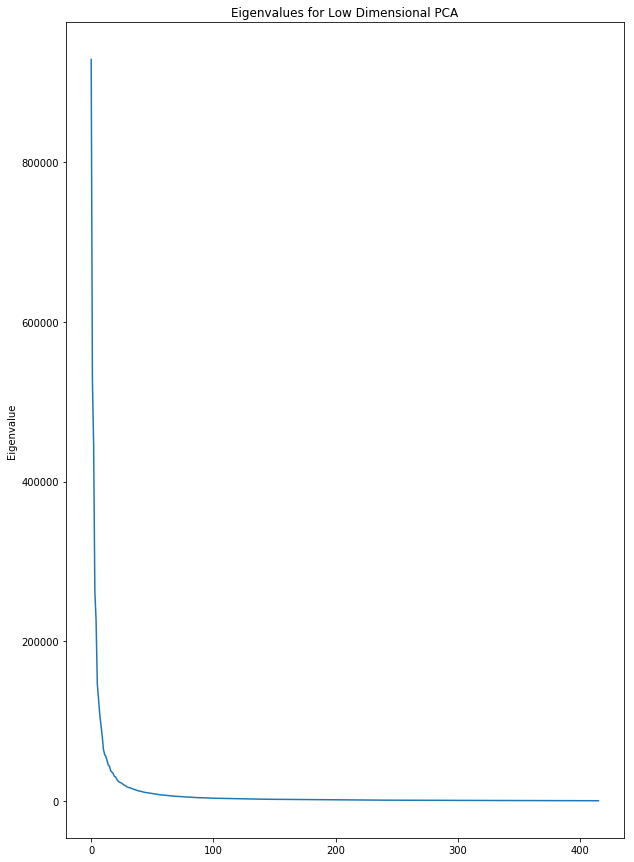

In [60]:
print(A.shape)
S_LDA = (1/N)*np.matmul(np.transpose(A),A)
w_lda, v_lda = np.linalg.eig(S_LDA)
inds = w_lda.argsort()[::-1]
w_lda = w_lda[inds]
v_lda = v_lda[:,inds]
plt.plot(w_lda)
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues for Low Dimensional PCA')
plt.show()

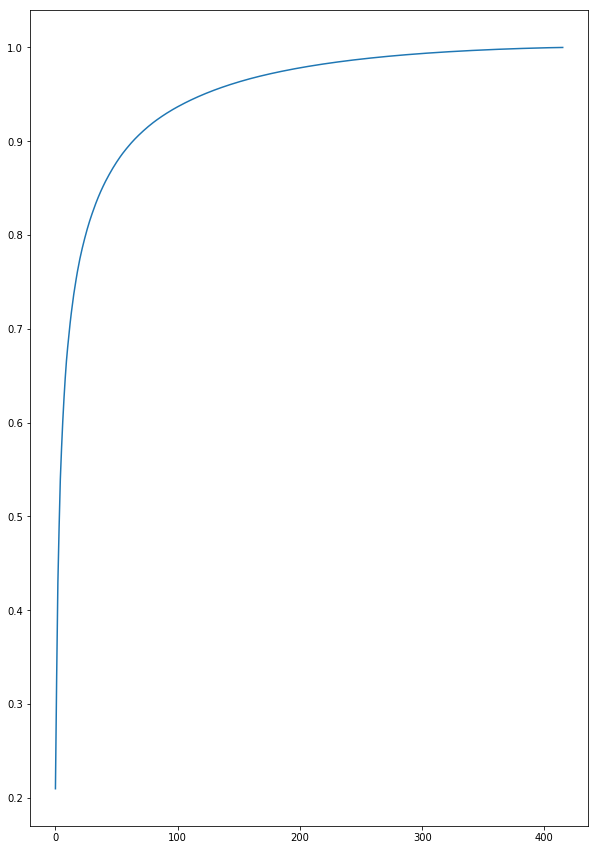

In [61]:
cum_w = np.cumsum(w_lda)/np.sum(w_lda)
plt.plot(cum_w)
plt.show()

In [62]:
M = np.argmax(cum_w>0.95)
V = v_lda[:,:M]
U = preprocessing.normalize(np.matmul(A,V), axis=0)
omega = np.matmul(np.transpose(A),U)
print(M)

122


In [63]:
A_test = np.transpose(np.subtract(X_test,X_bar))
omega_test = np.matmul(A_test, U)
incorrect = 0
wrong = []
right = []
for i in range(len(l_test[0])):
    omega_diff = np.subtract(omega,omega_test[i])
    train_index = np.argmin(np.diag(np.matmul(omega_diff,np.transpose(omega_diff))))
    if l_train[0][train_index] != l_test[0][i]:
        wrong.append([[l_test[0][i], i], [l_train[0][train_index], train_index]])
    else:
        right.append([[l_test[0][i], i], [l_train[0][train_index], train_index]])

In [64]:
print("Correct = " + str(round((1-len(wrong)/len(l_test[0]))*100,2)) + '%')

Correct = 60.58%


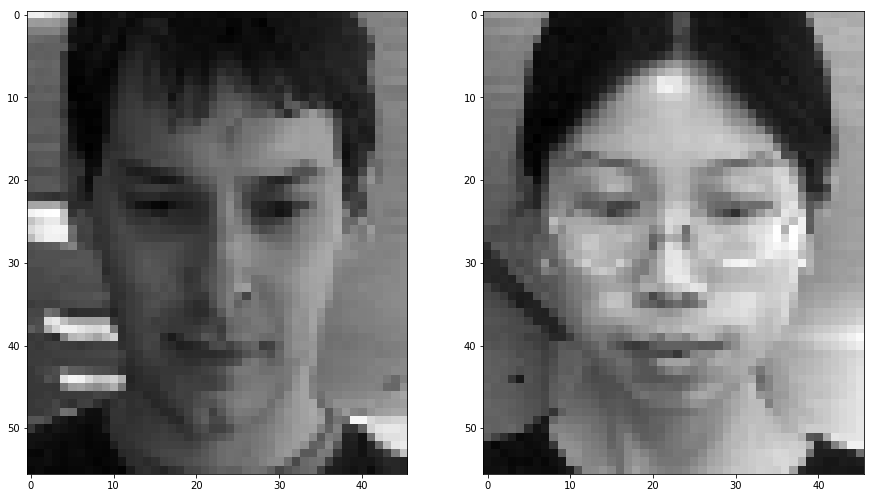

In [65]:
plt.figure(figsize=(15.0,9.0))
incorrect = wrong[5]
test_img = np.transpose(np.array_split(np.transpose(X_test)[incorrect[0][1]]/255, W))
train_img = np.transpose(np.array_split(np.transpose(X_train)[incorrect[1][1]]/255, W))
ax = plt.subplot(1, 2, 1)
ax.imshow(test_img, cmap='gray')
ax = plt.subplot(1, 2, 2)
ax.imshow(train_img, cmap='gray')

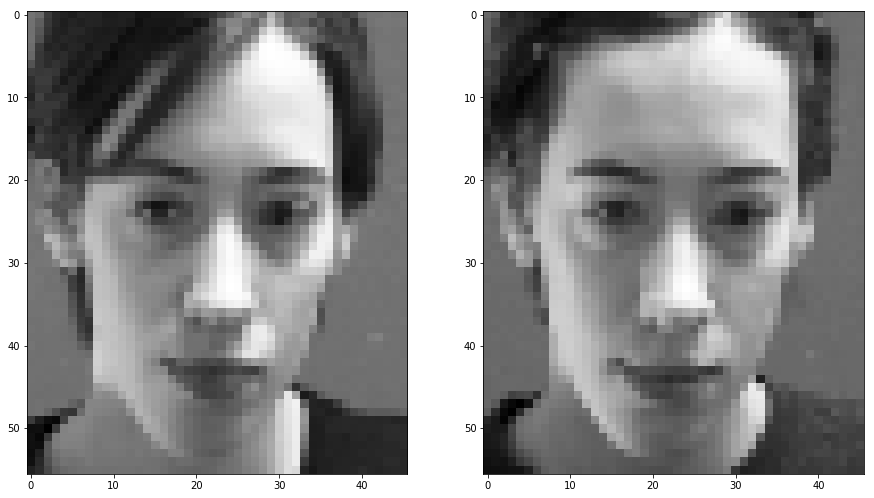

In [66]:
plt.figure(figsize=(15.0,9.0))
correct = right[0]
test_img = np.transpose(np.array_split(np.transpose(X_test)[correct[0][1]]/255, W))
train_img = np.transpose(np.array_split(np.transpose(X_train)[correct[1][1]]/255, W))
ax = plt.subplot(1, 2, 1)
ax.imshow(test_img, cmap='gray')
ax = plt.subplot(1, 2, 2)
ax.imshow(train_img, cmap='gray')

In [67]:
# m_set = [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
m_max =300
time_data = []
memory_data = []
M_values = []
accuracy = []

mem_start= psutil.Process(os.getpid()).memory_info().rss
for M in range( 1, m_max): 
    time_start = timeit.default_timer()
#     mem_start= psutil.Process(os.getpid()).memory_info().rss
#     time_start = timeit.default_timer()
#     M = np.argmax(cum_w>ratio)
#     print('    ', M)
    M_values.append(M)
    V = v_lda[:,:M]
    U = preprocessing.normalize(np.matmul(A,V), axis=0)
    omega = np.matmul(np.transpose(A),U)
    A_test = np.transpose(np.subtract(X_test,X_bar))
    omega_test = np.matmul(A_test, U)
    incorrect = 0
    wrong = []
    right = []
    for i in range(len(l_test[0])):
        omega_diff = np.subtract(omega,omega_test[i])
        train_index = np.argmin(np.diag(np.matmul(omega_diff,np.transpose(omega_diff))))
        if l_train[0][train_index] != l_test[0][i]:
            wrong.append([[l_test[0][i], i], [l_train[0][train_index], train_index]])
        else:
            right.append([[l_test[0][i], i], [l_train[0][train_index], train_index]])
    mem_end = psutil.Process(os.getpid()).memory_info().rss
    time_end = timeit.default_timer()
    time_data.append(time_end-time_start)
    memory_data.append((mem_end-mem_start)/1024)
    accuracy.append(round((1-len(wrong)/len(l_test[0]))*100,2))
    
            


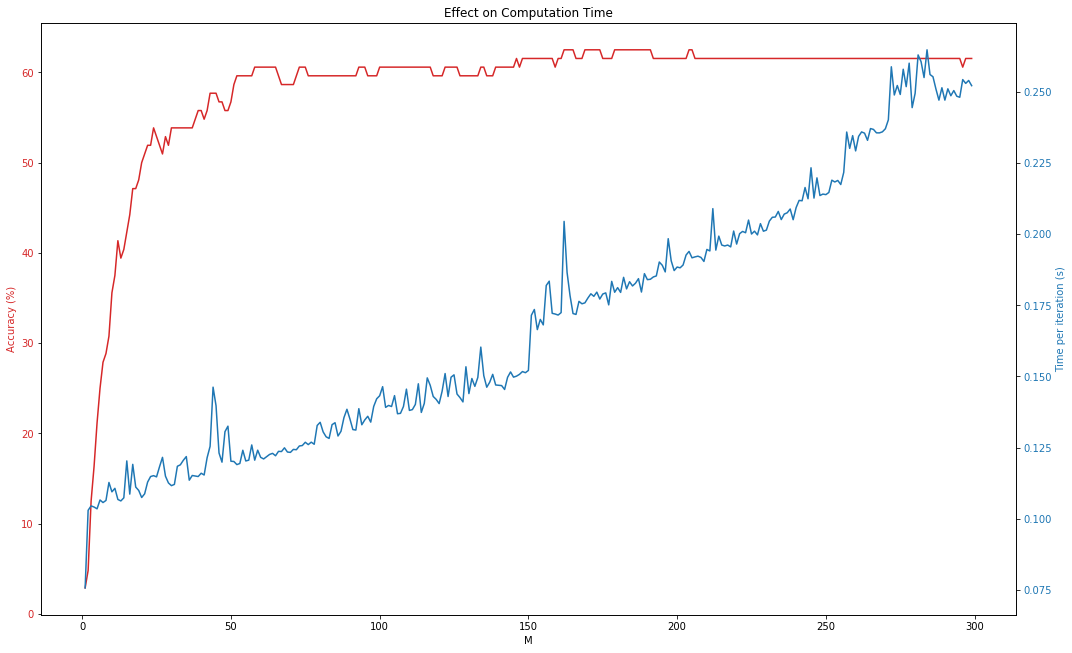

In [86]:
fig, ax1 = plt.subplots(figsize=(15.0,9.0))

color = 'tab:red'
ax1.set_xlabel('M')
ax1.set_ylabel('Accuracy (%)', color=color)
ax1.plot(M_values, accuracy, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Time per iteration (s)', color=color)  # we already handled the x-label with ax1
ax2.plot(M_values, time_data, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Effect on Computation Time')
plt.show()

In [87]:
scaled_memory_data =[]
for i in memory_data:
    scaled_memory_data.append(i +5000)

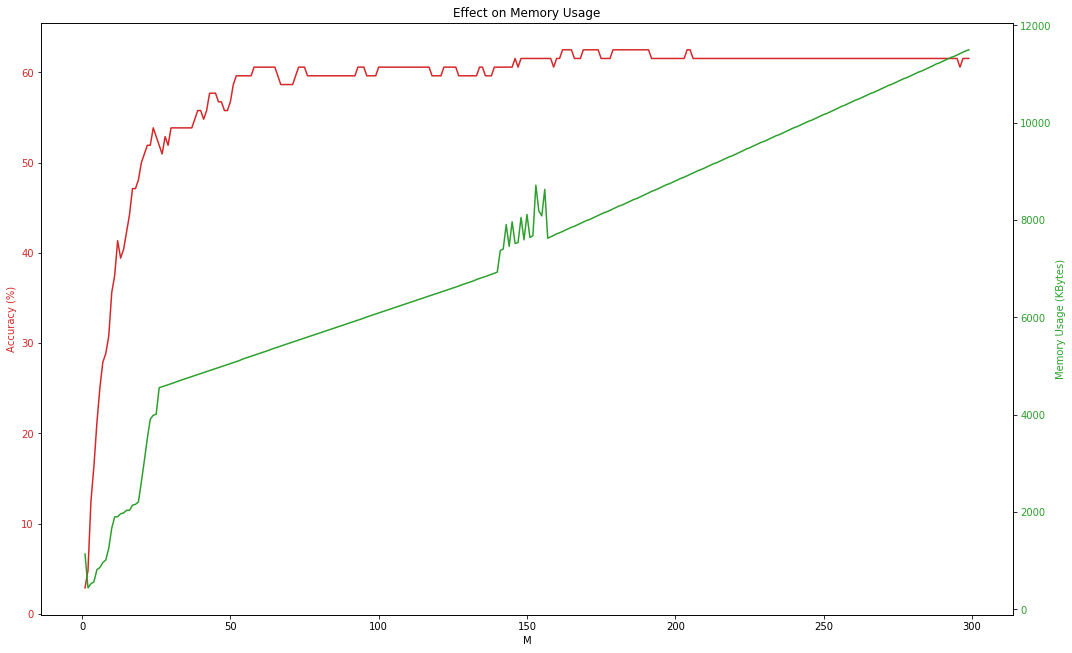

In [88]:
fig, ax1 = plt.subplots(figsize=(15.0,9.0))

color = 'tab:red'
ax1.set_xlabel('M')
ax1.set_ylabel('Accuracy (%)', color=color)
ax1.plot(M_values, accuracy, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax3 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:green'
ax3.set_ylabel('Memory Usage (KBytes)', color=color)  # we already handled the x-label with ax1
ax3.plot(M_values, scaled_memory_data, color=color)
ax3.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Effect on Memory Usage')
plt.show()